# PAE Tutorial

### step-by-step instructions for training a probabilsitic autoencoder with this package

In [1]:
# import this package 
from pytorch_pae import AE

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
# import pytorch
import torch

print(torch.__version__)

1.13.1


In [4]:
from torchinfo import summary

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Step 1: Choose your parameters

In [6]:
## data parameters
dataset       = 'MNIST'
loc           = './Datasets'

# number of layers in networks
n_layers     = 3

### convolutional net specific parameters ###

### Convolutions
# number of channels in each layer for convolutional neural net
out_channels = [16,16,16]
# kernel sizes in each layer for conv net
kernel_sizes = [9,2,6]
# padding values in each conv layer
paddings     = [5,2,5] #TODO: add suport for 'VALID' and 'SAME'
# stride values in each conv layer
strides      = [2,1,1]

### Pooling
# scaling factor in max pooling layer 
scale_facs   = [1,1,1] 

### Normalization
# whether t0 apply a layer normalization after conv layer
layer_norm   = [True,True,True]
# whether to train elemntwise affine parameters for normalization layer 
affine       = False
#############################################


### fully connected net specific parameters ###

# output size of each fully connected layer
out_sizes    = [256,128,64]
# whether to add a bias in each layer or not
bias         = [True, True, True]

## parameters that apply to both, fully connected and convolutional nets 
# dropout rate after each layer
dropout_rate = [0.4,0.4,0.8]

# whether to Lipschitz regularize by bounding the spectral norm 
spec_norm    = True
# activation function after each layer

activations  = ['ReLU', 'ReLU','ReLU']

##############################################


########### general parameters ###########
# data dimensionality
dim          = '2D'
# latent space dimensionality
latent_dim   = 8
# number of channels in data
input_c      = 1 
# data dimensioality along one axis (only square data supported in 2D)
input_dim    = 28

# type of encoder and decoder network (either 'fc' or 'conv')
encoder_type = 'conv'
decoder_type = 'conv'

# if True, the output is fed through a sigmoid layer to bring data values into range [0,1]
final_sigmoid = True
########################################


########## Training parameters #########
nepochs         = 40
batchsize       = 64
batchsize_valid = 256
initial_lr      = 1e-2

optimizer        = 'Adam'
# choose one of pytorch's or define your own
criterion1       = 'MSELoss'
criterion2       = 'MSELoss'
# when to switch from criterion1 to criterion2
ann_epoch        = 500

# choose one of pytorch's or define your own
scheduler        = 'ExponentialLR'
scheduler_params = {'gamma':0.98}

##### Just for contrastive learning --> ignore
contrastive      = False
tau              = 0.05
hidden_dim       = 2
########################################

In [7]:
general_params      = {'input_c': input_c, 
                       'input_dim': input_dim, 
                       'latent_dim': latent_dim, 
                       'encoder_type': encoder_type, 
                       'decoder_type': decoder_type,
                       'contrastive':contrastive, 
                       'dim': dim, 
                       'hidden_dim':hidden_dim}
conv_network_params = {'n_layers': n_layers, 
                       'out_channels': out_channels, 
                       'kernel_sizes': kernel_sizes, 
                       'scale_facs': scale_facs, 
                       'paddings': paddings,
                       'strides': strides,
                       'activations': activations, 
                       'spec_norm': spec_norm, 
                       'layer_norm': layer_norm,
                       'affine': affine,
                       'final_sigmoid': final_sigmoid, 
                       'bias':bias}
fc_network_params   = {'n_layers': n_layers, 
                       'out_sizes': out_sizes,
                       'activations': activations, 
                       'spec_norm': spec_norm, 
                       'dropout_rate':dropout_rate, 
                       'layer_norm': layer_norm, 
                       'affine': affine, 
                       'final_sigmoid': final_sigmoid, 
                       'bias':bias}

training_params     = {'batchsize': batchsize, 
                       'initial_lr': initial_lr, 
                       'optimizer': optimizer, 
                       'criterion1': criterion1, 
                       'criterion2': criterion2, 
                       'scheduler': scheduler, 
                       'scheduler_params':scheduler_params, 
                       'batchsize_valid': batchsize_valid, 
                       'ann_epoch':ann_epoch}
data_params         = {'dataset':dataset, 'loc': loc}

In [8]:
from torchvision import transforms

transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])

## Step 2: Set up and train the autoencoder

In [9]:
AE1 = AE.Autoencoder(params=general_params,
                     dparams=data_params,
                     nparams_enc=conv_network_params, 
                     nparams_dec=conv_network_params, 
                     tparams=training_params, 
                     device=device, 
                     transforms=transform)

In [10]:
# summary?

In [11]:
if dim =='1D':
    summary(AE1, (input_c,input_dim))
else:
    summary(AE1, (input_c, input_dim, input_dim))

In [12]:
summary(AE1, (input_c, input_dim, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [1, 1, 28, 28]            --
├─ConvEncoder: 1-1                       [1, 8]                    --
│    └─ModuleList: 2-1                   --                        --
│    │    └─Conv2d: 3-1                  [16, 15, 15]              1,312
│    │    └─LayerNorm: 3-2               [16, 15, 15]              --
│    │    └─ReLU: 3-3                    [16, 15, 15]              --
│    │    └─AdaptiveMaxPool2d: 3-4       [16, 15, 15]              --
│    │    └─Conv2d: 3-5                  [16, 18, 18]              1,040
│    │    └─LayerNorm: 3-6               [16, 18, 18]              --
│    │    └─ReLU: 3-7                    [16, 18, 18]              --
│    │    └─AdaptiveMaxPool2d: 3-8       [16, 18, 18]              --
│    │    └─Conv2d: 3-9                  [16, 23, 23]              9,232
│    │    └─LayerNorm: 3-10              [16, 23, 23]              --
│    │

In [13]:
# train_loss, valid_loss = AE1.train_autoencoder(nepochs)

epoch: 1, training loss: 3.7074e-02, validation loss: 2.1173e-02, learning rate: 1.0000e-02
epoch: 2, training loss: 2.0582e-02, validation loss: 1.8792e-02, learning rate: 9.8000e-03
epoch: 3, training loss: 1.8524e-02, validation loss: 1.6594e-02, learning rate: 9.6040e-03
epoch: 4, training loss: 1.7322e-02, validation loss: 1.7259e-02, learning rate: 9.4119e-03
epoch: 5, training loss: 1.6620e-02, validation loss: 1.5850e-02, learning rate: 9.2237e-03
epoch: 6, training loss: 1.6182e-02, validation loss: 1.5866e-02, learning rate: 9.0392e-03
epoch: 7, training loss: 1.5795e-02, validation loss: 1.6151e-02, learning rate: 8.8584e-03
epoch: 8, training loss: 1.5517e-02, validation loss: 1.5223e-02, learning rate: 8.6813e-03
epoch: 9, training loss: 1.5291e-02, validation loss: 1.6119e-02, learning rate: 8.5076e-03
saved model to "./AE.ckpt"
epoch: 10, training loss: 1.5107e-02, validation loss: 1.5146e-02, learning rate: 8.3375e-03
epoch: 11, training loss: 1.4931e-02, validation los

In [13]:
AE1.load_model('.')

True

NameError: name 'train_loss' is not defined

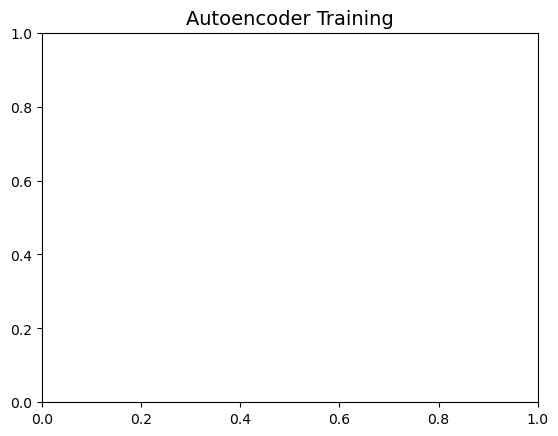

In [20]:
plt.figure()
plt.title('Autoencoder Training',fontsize=14)
plt.plot(train_loss, label='training')
plt.plot(valid_loss, label='validation')
plt.xlabel('epoch',fontsize=13)
plt.ylabel('loss',fontsize=13)
plt.legend(fontsize=13)
plt.show()

## Data reconstructions

In [14]:
from pytorch_pae.data_loader import *

In [15]:
data_params['dataset']

'MNIST'

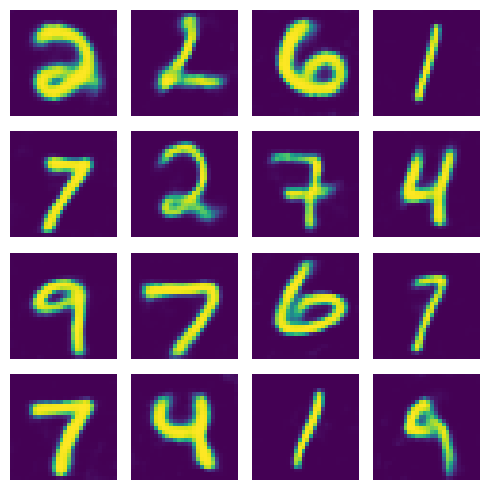

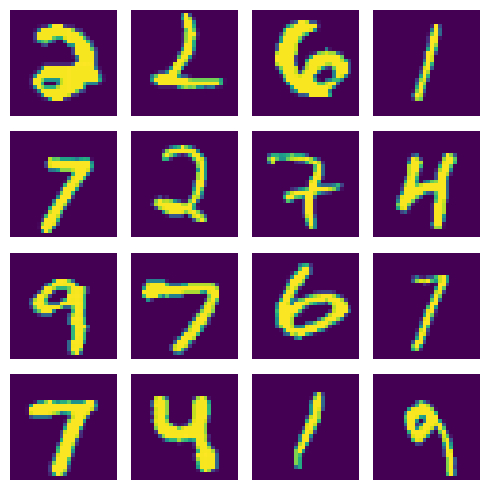

In [16]:
train_loader, valid_loader, test_loader= get_data(data_params['dataset'],data_params['loc'],16, 16, transform)

data, _  = next(iter(train_loader))

recon = AE1.forward(data.to(device))

fig, ax = plt.subplots(4,4,figsize=(5,5))
ax = ax.flatten()
for ii in range(16):
    ax[ii].imshow(np.squeeze(recon[ii].cpu().detach().numpy()))
    ax[ii].axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(4,4,figsize=(5,5))
ax = ax.flatten()
for ii in range(16):
    ax[ii].imshow(np.squeeze(data[ii].cpu().detach().numpy()))
    ax[ii].axis('off')
plt.tight_layout()
plt.show()


In [17]:
from pathlib import Path
Path('Models/Tutorials').mkdir(exist_ok=True, parents=True)

In [21]:
torch.save(AE1, os.path.join('./Models/Tutorials', 'AE'))

## Step 3: Train the density estimator on the encoded data

In [18]:
# import density estimation module
from sinf import GIS

In [19]:
# load auutoencoder
AE1 = torch.load(os.path.join('./Models/Tutorials', 'AE'))

In [20]:
from pytorch_pae.data_loader import *

In [21]:
# encode data

train_loader, valid_loader, test_loader = get_data(data_params['dataset'],data_params['loc'],-1, -1, transform)

data, _  = next(iter(train_loader))
data     = data.to(device)

valid_data, _  = next(iter(valid_loader))
valid_data     = valid_data.to(device)

with torch.no_grad():
    encoded_train = AE1.encoder.forward(data)
    encoded_valid = AE1.encoder.forward(valid_data)

In [22]:
encoded_train.shape

torch.Size([60000, 8])

In [23]:
encoded_valid.shape

torch.Size([60000, 8])

In [24]:
encoded_train.device

device(type='cuda', index=0)

In [26]:
# train density estimator (set verbose=True to see training progress)
gis = GIS.GIS(data_train=encoded_train, 
              data_validate=encoded_valid,
              iteration=500,
              verbose=True, 
              nocuda=False)

/gpfs/share/home/2106395012/tools/SINF/sinf/SINF.py:494: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2349.)
  Q, R = torch.qr(ATi)


Fit A: Time: 1.0199541625976563 Wasserstein Distance: [6.902698040008545, 5.923625469207764, 5.413100719451904, 4.590785503387451, 4.210358619689941, 3.366851329803467, 3.075916051864624, 1.7886466979980469]
Fit spline Time: 0.04354057693481445
logp: -114.60799407958984 -114.48816680908203 time: 1.209265947341919 iteration: 1 best: 1
Fit A: Time: 0.31176907348632815 Wasserstein Distance: [6.269961357116699, 5.378479957580566, 4.915567874908447, 4.167295455932617, 3.82159686088562, 3.063042402267456, 2.7814583778381348, 1.6221240758895874]
Fit spline Time: 0.041987167358398435
logp: -99.68035888671875 -99.57710266113281 time: 0.43062329292297363 iteration: 2 best: 2
Fit A: Time: 0.4778936462402344 Wasserstein Distance: [5.693789005279541, 4.883336067199707, 4.46204137802124, 3.7834935188293457, 3.4667749404907227, 2.778684616088867, 2.523136854171753, 1.4710217714309692]
Fit spline Time: 0.0321577262878418
logp: -87.20882415771484 -87.11959838867188 time: 0.5868954658508301 iteration: 3

In [27]:
torch.save(gis, os.path.join('./Models/Tutorials', 'GIS'))

## Density Estimation and Outlier Detection

In [28]:
logps       = gis.evaluate_density(encoded_train)
logps_valid = gis.evaluate_density(encoded_valid)

In [29]:
logps       = logps.cpu().detach().numpy()
logps_valid = logps_valid.cpu().detach().numpy()

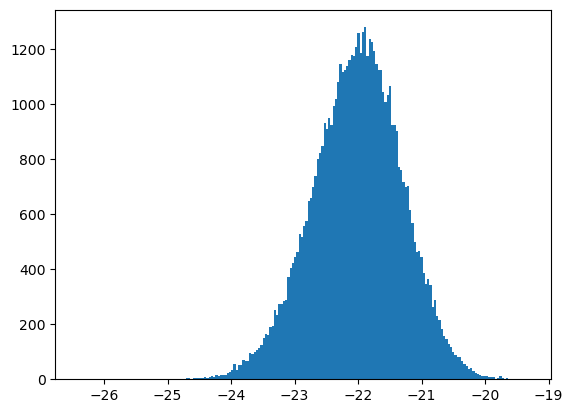

In [30]:
_       = plt.hist(logps,bins=200)

In [31]:
ranking = np.argsort(logps)

### Digits with lowest probability

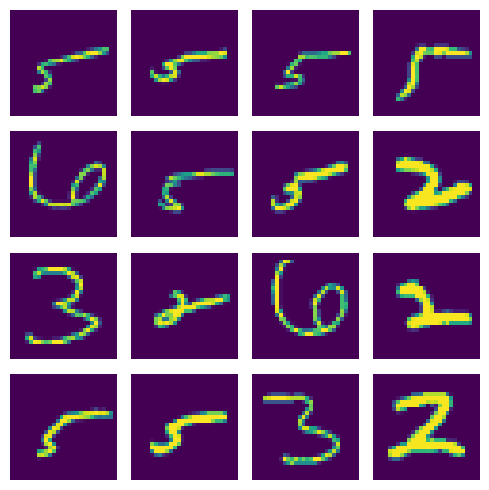

In [32]:
fig, ax = plt.subplots(4,4,figsize=(5,5))
ax = ax.flatten()
for ii in range(16):
    ax[ii].imshow(np.squeeze(data[ranking[ii]].cpu().detach().numpy()))
    ax[ii].axis('off')
plt.tight_layout()
plt.show()

## Data Generation

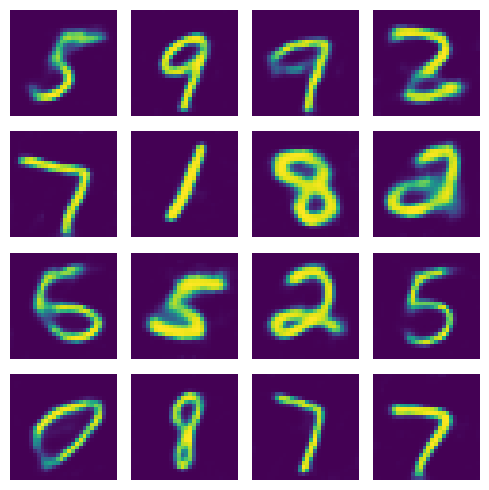

In [33]:
samples, _ = gis.sample(16)
with torch.no_grad():
    decoded_samples = AE1.decoder.forward(samples)

fig, ax = plt.subplots(4,4,figsize=(5,5))
ax = ax.flatten()
for ii in range(16):
    ax[ii].imshow(np.squeeze(decoded_samples[ii].cpu().detach().numpy()))
    ax[ii].axis('off')
plt.tight_layout()
plt.show()
